

## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



## Автор

Aleksandr_Morshinin_186851487

## Комментарий автора

Использовал чуть-чуть улучшенную модель из примера и AdamW. Данные расширил с помощью OverSampling и аугментации (сделал просто руками средаствами винды, если нужно могу выслать итоговый датасет).
Финальный score на каггле **0.94155** (к сожалению, не хватило времени поработать над моделью). С воспроизводимостью тоже не все хорошо, кажется установил все seed, но результаты +- плавают от запуска к запуску.

### Установка зависимостей

In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
!nvidia-smi
import torch
torch.cuda.is_available()

Mon Apr 26 16:01:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 457.51       Driver Version: 457.51       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 206... WDDM  | 00000000:01:00.0  On |                  N/A |
| 43%   54C    P8    17W / 175W |   1052MiB /  8192MiB |     12%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

*Выставим постоянный сид для торча*

In [3]:
torch.manual_seed(17)

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [4]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [5]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [6]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [7]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [8]:
TRAIN_DIR = Path('train/dataset')
TEST_DIR = Path('test/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [9]:
len(train_val_files)

43022

In [10]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels, random_state=17)

In [11]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

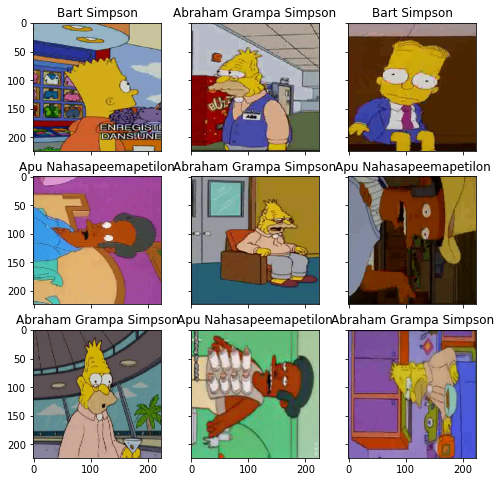

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение нейросети
Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


*Коммент: поменял размер выходов, накинул batch norm, добавил dropout. В принципе это все изменения относительно базовой модели.*

In [18]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        
        self.batch1 = nn.Sequential(
            nn.BatchNorm2d(32)
        )
        self.batch2 = nn.Sequential(
            nn.BatchNorm2d(64)
        )
        self.batch3 = nn.Sequential(
            nn.BatchNorm2d(128)
        )
        self.batch4 = nn.Sequential(
            nn.BatchNorm2d(256)
        )
        self.batch5 = nn.Sequential(
            nn.BatchNorm2d(512)
        )
        
        self.dropout = nn.Sequential(
            nn.Dropout(0.4)
        )
        
        
        self.out = nn.Linear(512 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.conv2(x)
        x = self.batch2(x)
        x = self.conv3(x)
        x = self.batch3(x)
        x = self.conv4(x)
        x = self.batch4(x)
        x = self.conv5(x)
        x = self.batch5(x)

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        
        logits = self.out(x)
        return logits

In [19]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [20]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

*Добавим AdamW в качестве оптимизатора*.

In [21]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [22]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [23]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (batch1): Sequential(
    (0): B

Запустим обучение сети.

In [24]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [25]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=18, batch_size=128)

epoch:   0%|          | 0/18 [00:00<?, ?it/s]

loss 2.1480345060730324


epoch:   6%|▌         | 1/18 [02:19<39:38, 139.89s/it]


Epoch 001 train_loss: 2.1480     val_loss 1.5848 train_acc 0.5137 val_acc 0.6402
loss 0.8593809475703964


epoch:  11%|█         | 2/18 [04:34<36:31, 136.98s/it]


Epoch 002 train_loss: 0.8594     val_loss 0.9483 train_acc 0.7690 val_acc 0.7589
loss 0.5579265317419122


epoch:  17%|█▋        | 3/18 [06:47<33:47, 135.18s/it]


Epoch 003 train_loss: 0.5579     val_loss 0.7822 train_acc 0.8467 val_acc 0.8181
loss 0.2838228737761894


epoch:  22%|██▏       | 4/18 [09:02<31:27, 134.79s/it]


Epoch 004 train_loss: 0.2838     val_loss 0.8342 train_acc 0.9180 val_acc 0.8014
loss 0.2690277385716427


epoch:  28%|██▊       | 5/18 [11:21<29:33, 136.40s/it]


Epoch 005 train_loss: 0.2690     val_loss 0.6734 train_acc 0.9210 val_acc 0.8528
loss 0.13482652806719586


epoch:  33%|███▎      | 6/18 [13:42<27:34, 137.89s/it]


Epoch 006 train_loss: 0.1348     val_loss 0.9198 train_acc 0.9592 val_acc 0.8272
loss 0.15400434379844977


epoch:  39%|███▉      | 7/18 [16:02<25:24, 138.55s/it]


Epoch 007 train_loss: 0.1540     val_loss 0.8923 train_acc 0.9542 val_acc 0.8584
loss 0.1950522518967883


epoch:  44%|████▍     | 8/18 [18:21<23:07, 138.78s/it]


Epoch 008 train_loss: 0.1951     val_loss 1.0415 train_acc 0.9477 val_acc 0.8573
loss 0.12550836477513622


epoch:  50%|█████     | 9/18 [20:40<20:49, 138.87s/it]


Epoch 009 train_loss: 0.1255     val_loss 0.9132 train_acc 0.9651 val_acc 0.8588
loss 0.11373699358685524


epoch:  56%|█████▌    | 10/18 [22:57<18:26, 138.31s/it]


Epoch 010 train_loss: 0.1137     val_loss 0.8449 train_acc 0.9701 val_acc 0.8682
loss 0.1602997741720444


epoch:  61%|██████    | 11/18 [25:13<16:04, 137.73s/it]


Epoch 011 train_loss: 0.1603     val_loss 1.0309 train_acc 0.9596 val_acc 0.8487
loss 0.11868531343505836


epoch:  67%|██████▋   | 12/18 [27:30<13:43, 137.30s/it]


Epoch 012 train_loss: 0.1187     val_loss 0.8422 train_acc 0.9715 val_acc 0.8818
loss 0.08828739705254522


epoch:  72%|███████▏  | 13/18 [29:44<11:22, 136.47s/it]


Epoch 013 train_loss: 0.0883     val_loss 0.9852 train_acc 0.9775 val_acc 0.8744
loss 0.0845862654146475


epoch:  78%|███████▊  | 14/18 [31:55<08:58, 134.65s/it]


Epoch 014 train_loss: 0.0846     val_loss 0.9728 train_acc 0.9790 val_acc 0.8870
loss 0.0910965288401404


epoch:  83%|████████▎ | 15/18 [34:04<06:39, 133.13s/it]


Epoch 015 train_loss: 0.0911     val_loss 1.0960 train_acc 0.9768 val_acc 0.8795
loss 0.07876518573227508


epoch:  89%|████████▉ | 16/18 [36:55<04:48, 144.46s/it]


Epoch 016 train_loss: 0.0788     val_loss 1.0758 train_acc 0.9806 val_acc 0.8714
loss 0.10205536687290652


epoch:  94%|█████████▍| 17/18 [40:59<02:54, 174.25s/it]


Epoch 017 train_loss: 0.1021     val_loss 1.0206 train_acc 0.9767 val_acc 0.8677
loss 0.08903738298618896


epoch: 100%|██████████| 18/18 [43:09<00:00, 143.85s/it]


Epoch 018 train_loss: 0.0890     val_loss 1.0366 train_acc 0.9791 val_acc 0.8809


Построим кривые обучения

In [26]:
loss, acc, val_loss, val_acc = zip(*history)

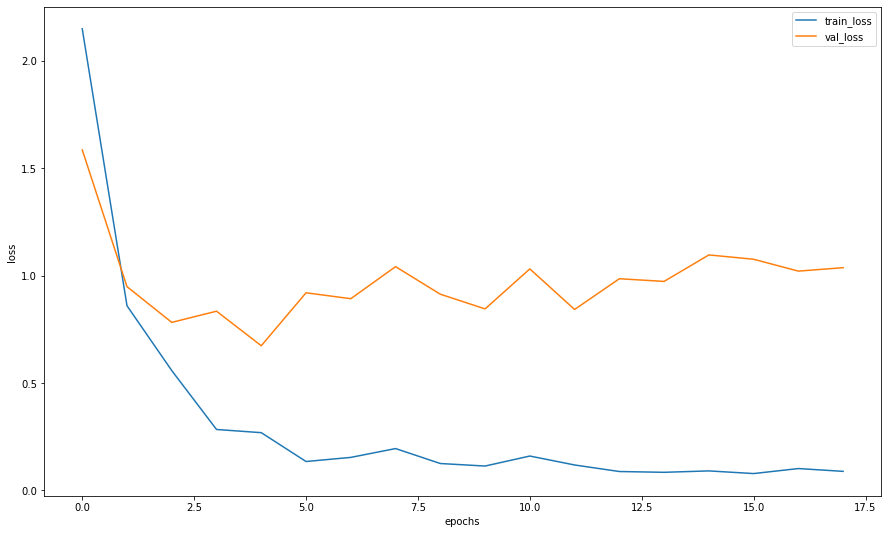

In [27]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

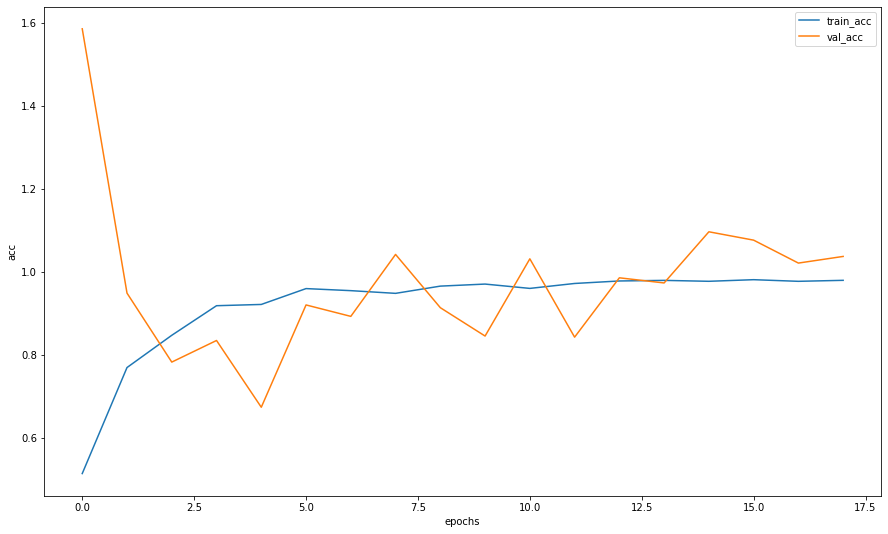

In [29]:
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_loss, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

In [41]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [26]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [37]:
idxs = [i for i in range(len(val_dataset))]
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [38]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [39]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [30]:
actual_labels = [label_encoder.classes_[i] for i in actual_labels]

In [32]:
from sklearn.metrics import f1_score

f1_score(actual_labels, preds_class, average='micro')

0.8881161971830986

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

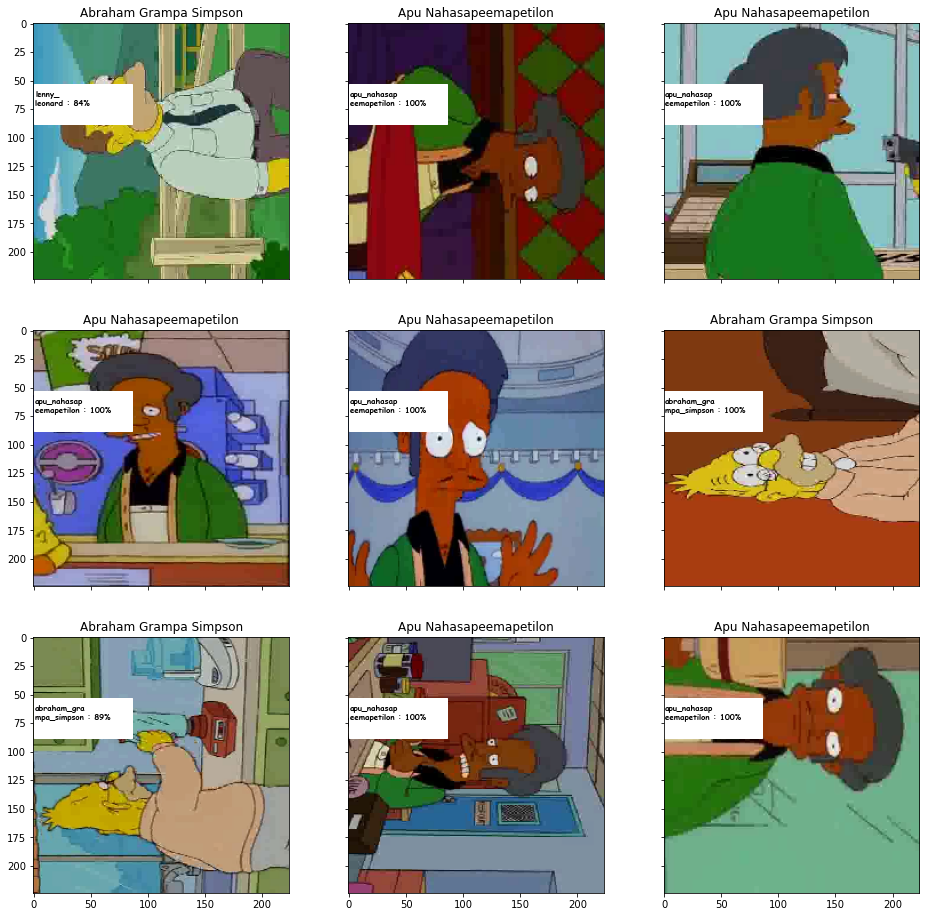

In [42]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(16, 16), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [43]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [44]:
import pandas as pd
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [45]:
my_submit.to_csv('simple_cnn_baseline_2.csv', index=False)

## Вывод

1. К сожалению не дошел до методов дообучения сеток.
2. Финальный score 0.94155 получен с помощью накрутки параметров сети, AdamW и оверсемплинга и аугментации данных (как писал выше, полученный датасет могу выслать, но можно заметить, что появились новые картинки и при сэмплировании картинок).
3. Сделать 100% воспроизводимый результат не получилось, хотя seed установлен.